In [1]:
import sklearn
import numpy as np
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
 
for i in (sklearn, np, mpl):
    print(i.__name__,": ",i.__version__,sep="")

sklearn: 0.22
numpy: 1.19.5
matplotlib: 2.1.0


## 8.2 降维的主要方法

### 8.2.1 投影

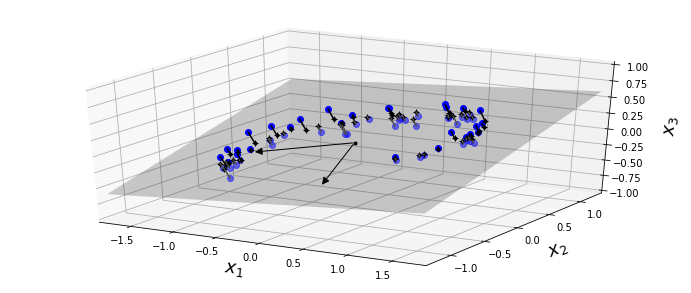

In [88]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

# 原数据（三维空间数据集 60x3）
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

from sklearn.decomposition import PCA

# PCA 
pca = PCA(n_components = 2)
# 训练 降维至 2维
X2D = pca.fit_transform(X)
# 反转 重建至 3维
X3D_inv = pca.inverse_transform(X2D)
 
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
 
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
 
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
# 坐标轴范围
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]
# x 轴
x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

# 主成分PC的方向
C = pca.components_
R = C.T.dot(C)
# 投影的平面
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])
 
from mpl_toolkits.mplot3d import Axes3D
 
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')

# 绘制 原数据 比 重建数据 小的点集
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)
# 绘制 原数据 比 重建数据 大的点集
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
# 绘制 重建数据点集
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

# 绘制 投影的平面
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")

np.linalg.norm(C, axis=0)

# 绘制 主成分PC1 单位向量
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
# 绘制 主成分PC2 单位向量
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
# 绘制 单位向量原点
ax.plot([0], [0], [0], "k.")

# 绘制 原数据 与 重建数据之间的距离线段
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
 
plt.show()

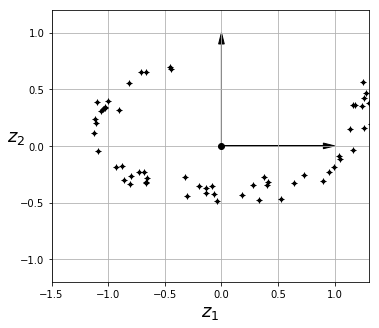

In [3]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, aspect='equal')

# 绘制 二维平面上的 投影后数据
ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")

ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
 
plt.show()

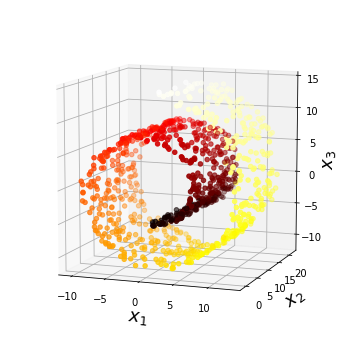

In [4]:
from sklearn.datasets import make_swiss_roll
 
from mpl_toolkits.mplot3d import Axes3D

# 原数据（瑞士卷数据集、目标值）
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
# print(X.shape)
# print(t.shape)

axes = [-11.5, 14, -2, 23, -12, 15]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")

# 绘制 原始三维数据点集
ax.scatter(X[:,0],X[:,1],X[:,2],c=t, cmap=plt.cm.hot)

ax.view_init(10,-70)
ax.set_xlabel("$x_1$",fontsize=18)
ax.set_ylabel("$x_2$",fontsize=18)
ax.set_zlabel("$x_3$",fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
 
plt.tight_layout()
plt.show()

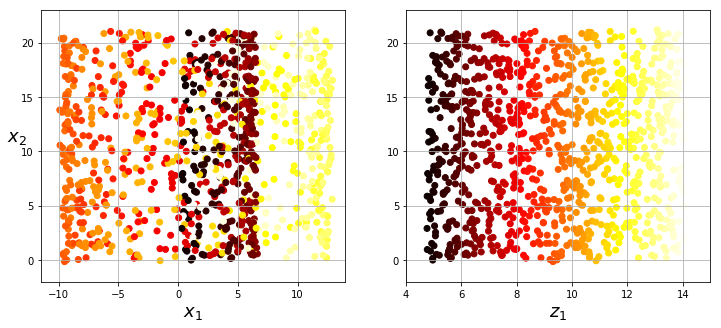

In [5]:
plt.figure(figsize=(12, 5))

# 左图
plt.subplot(121)
# 投影到平面上（投影 实际无法得到好的数据分类分布 直接丢弃了x3）
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# 右图 
plt.subplot(122)
# 展开瑞士卷 横坐标为目标值t（流形 实际需要做展开 z1相当于x1和x3的特征）
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
 
plt.show()

### 8.2.2 流形学习

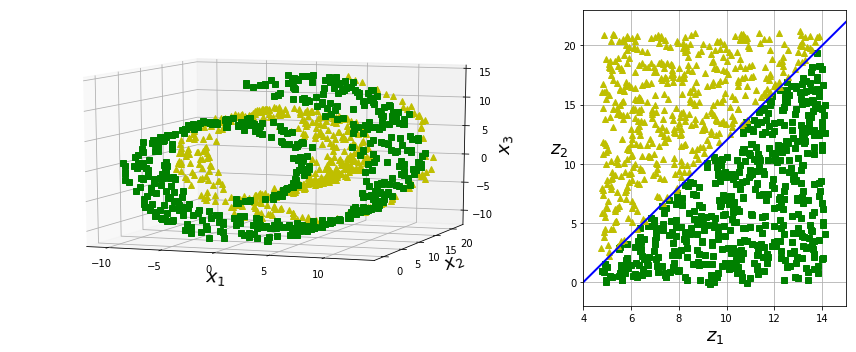

In [6]:
from matplotlib import gridspec
 
axes = [-11.5, 14, -2, 23, -12, 15]
 
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)
 

# 瑞士卷流形数据 线性不可分 降维后线性可分
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1,2 ,width_ratios=[2,1])
 
positive_class = 2 * (t[:] -4) > X[:,1]
X_pos = X[positive_class]
X_neg = X[~positive_class]

# 左图
ax = plt.subplot(gs[0], projection="3d")
ax.view_init(10, -70)
# 绘制 原始三维数据点集
ax.plot(X_neg[:,0], X_neg[:,1], X_neg[:,2],"y^")
ax.plot(X_pos[:,0], X_pos[:,1], X_pos[:,2],"gs")
ax.set_xlabel("$x_1$",fontsize=18)
ax.set_ylabel("$x_2$",fontsize=18)
ax.set_zlabel("$x_3$",fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# 右图
ax = plt.subplot(gs[1])
# 展开瑞士卷 横坐标为目标值t
plt.plot(t[positive_class], X[positive_class,1],"gs")
plt.plot(t[~positive_class], X[~positive_class,1],"y^")
# 绘制 决策边界
plt.plot([4,15],[0,22],"b-",linewidth=2)
plt.axis([4,15,axes[2],axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$",fontsize=18,rotation=0)
plt.grid(True)
 
plt.tight_layout()
plt.show()

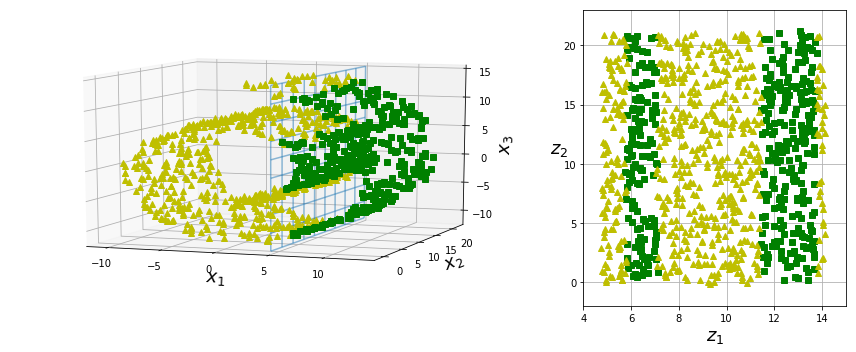

In [7]:
# 瑞士卷流形数据 线性可分 降维后线性不可分
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1,2 ,width_ratios=[2,1])
 
positive_class = X[:,0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]

# 左图
ax = plt.subplot(gs[0], projection="3d")
ax.view_init(10, -70)
# 绘制 原始三维数据点集
ax.plot(X_neg[:,0], X_neg[:,1], X_neg[:,2],"y^")
# 绘制 决策边界
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:,0], X_pos[:,1], X_pos[:,2],"gs")
ax.set_xlabel("$x_1$",fontsize=18)
ax.set_ylabel("$x_2$",fontsize=18)
ax.set_zlabel("$x_3$",fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# 右图
ax = plt.subplot(gs[1])
# 展开瑞士卷 横坐标为目标值t
plt.plot(t[positive_class], X[positive_class,1],"gs")
plt.plot(t[~positive_class], X[~positive_class,1],"y^")
plt.axis([4,15,axes[2],axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$",fontsize=18,rotation=0)
plt.grid(True)
 
plt.tight_layout()
plt.show()

## 8.3 PCA

### 8.3.1 保留差异性

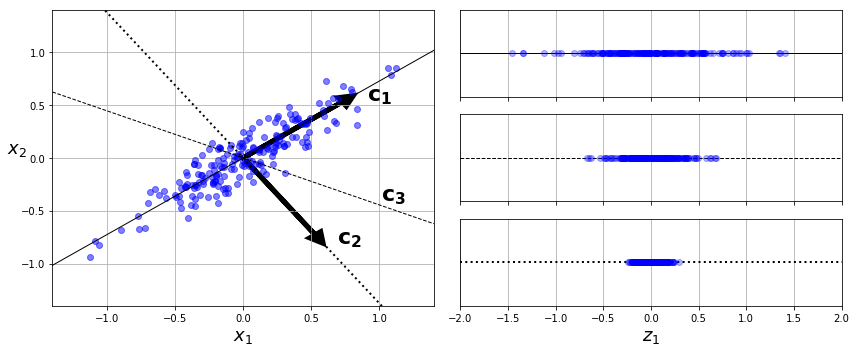

In [8]:
angle = np.pi / 5
stretch = 5
m = 200
 
np.random.seed(3)
# 原数据（200个样本 每个样本2个特征）
X = np.random.randn(m, 2) / 10
# 拉伸
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
# 旋转
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

# 不同主成分上的 投影操作
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

# 不同主成分上的 投影后数据
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))
 
plt.figure(figsize=(12,5))
 
plt.subplot2grid((3,2), (0, 0), rowspan=3)

# 绘制 原数据点集
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
# 绘制 主成分PC 直线
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
# 绘制 主成分PC 向量
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
# 标注 主成分PC 文字
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.text(u2[0] + 0.1, u2[1], r"$\mathbf{c_3}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# 右一
plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
# 绘制 主成分PC1上的 投影后数据
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

# 右二
plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
# 绘制 主成分PC3上的 投影后数据
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

# 右三
plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
# 绘制 主成分PC2上的 投影后数据
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
 
plt.tight_layout()
plt.show()

### 8.3.2 主要成分

In [9]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5

# 原数据（60个样本 每个样本3个特征）
X = np.empty((m,3))
X[:,0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
X[:,1] = np.sin(angles) * 0.7 + noise * np.random.randn(m)/2
X[:,2] = X[:,0]*w1 + X[:,1] * w2 + noise * np.random.randn(m) # 与前两个特征相关联
 
X.shape

(60, 3)

In [10]:
# （1）自主实现

# （1.1）数据预处理 以原点为中心
X_centered = X - X.mean(axis=0)

# （1.2）奇异值分解
U, s, Vt = np.linalg.svd(X_centered)

# 主成分PC1 单位向量
c1 = Vt.T[:,0]
# 主成分PC2 单位向量
c2 = Vt.T[:,1]
print(c1, c2)
print(U.shape, X.shape, Vt.shape)

[0.93636116 0.29854881 0.18465208] [-0.34027485  0.90119108  0.2684542 ]
(60, 60) (60, 3) (3, 3)


In [11]:
# 比较 X_centered = U S VT

m, n = X.shape
 
S = np.zeros(X_centered.shape)
# print(S.shape)
# print(S)
# print(s)

# array 是一个1维数组时 结果形成一个以一维数组为对角线元素的矩阵
# array 是一个2维数组时 结果输出数组的对角线元素
S[:n, :n] = np.diag(s)
# print(np.diag(s))
# print(S.shape)
# print(S)

# np.allclose()函数判断两个矩阵每个元素是否相等 默认误差1e-05
np.allclose(X_centered, U.dot(S).dot(Vt)) 

True

### 8.3.3 向下投影到 d 维度

In [12]:
# （1.3）选择前d=2个单位向量
W2= Vt.T[:,:2]

# （1.4）投影后数据
X2D = X_centered.dot(W2)

# 拷贝一份方便后面对比
X2D_using_svd = X2D  

print("X shape: ",X.shape)
print("X2D shape:", X2D.shape)

X shape:  (60, 3)
X2D shape: (60, 2)


### 8.3.4 使用 Scikit-Learn

In [13]:
# （2）自动实现
from sklearn.decomposition import PCA

# （2.1）PCA 指定降到 d维
pca = PCA(n_components=2)

# （2.2）训练 降维至 d维
X2D = pca.fit_transform(X)  # sklearn会自动进行中心化的处理

print(X2D.shape)

(60, 2)


In [14]:
# 比较 SVD降维 = PCA降维 
print(X2D_using_svd[:5])
print(X2D[:5])

np.allclose(-X2D_using_svd, X2D)

[[-1.26203346 -0.42067648]
 [ 0.08001485  0.35272239]
 [-1.17545763 -0.36085729]
 [-0.89305601  0.30862856]
 [-0.73016287  0.25404049]]
[[ 1.26203346  0.42067648]
 [-0.08001485 -0.35272239]
 [ 1.17545763  0.36085729]
 [ 0.89305601 -0.30862856]
 [ 0.73016287 -0.25404049]]


True

In [15]:
# 重建至3维
X3D = pca.inverse_transform(X2D)
X3D.shape

(60, 3)

In [16]:
# 比较 原始数据 ≠ 重建数据（信息差）
print(X[:5])
print(X3D[:5])

np.allclose(X3D, X)

[[-1.01570027 -0.55091331 -0.26132626]
 [-0.00771675  0.59958572  0.03507755]
 [-0.95317135 -0.46453691 -0.24920288]
 [-0.92012304  0.21009593  0.02182381]
 [-0.76309739  0.158261    0.19152496]]
[[-1.01450604 -0.54656333 -0.27441525]
 [-0.02103231  0.55108376  0.18101894]
 [-0.95379477 -0.4668077  -0.24237013]
 [-0.91717404  0.22083765 -0.01049779]
 [-0.74607229  0.22027492  0.00492637]]


False

In [17]:
# 计算 原始数据和重建数据 平均方差（信息差）
np.mean(np.sum(np.square(X3D - X), axis=1))

0.010170337792848549

In [18]:
# Wd = Vt.T[:,:2] 选择前d=2个单位向量
Vt.T[:,:2]

array([[ 0.93636116, -0.34027485],
       [ 0.29854881,  0.90119108],
       [ 0.18465208,  0.2684542 ]])

In [19]:
pca.components_.T[:,:2]

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])

In [20]:
# WdT = Vt[:2] 主成分单位向量的转置
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [21]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

### 8.3.5 可解释方差比

In [22]:
# 每个成分的数据集方差比
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [23]:
# 丢失的信息差
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

### 8.3.6 选择正确的维度 d

In [24]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# 原数据（MNIST数据集）
mnist = fetch_openml("mnist_784", version=1)
mnist.target = mnist.target.astype(np.uint8)

# 划分训练集、测试集
X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"]) # 默认拆分比例4:1
 
for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(52500, 784)
(17500, 784)
(52500,)
(17500,)


In [25]:
# （1）PCA 先不指定降到几维
pca = PCA()
# 训练 不会降到几维
pca.fit(X_train)
# 计算 保留95%方差 所需的最小维度 d
cumsum = np.cumsum(pca.explained_variance_ratio_)
# print(cumsum)
# print(cumsum.shape) # (784, )
d = np.argmax(cumsum>=0.95)+1
d

154

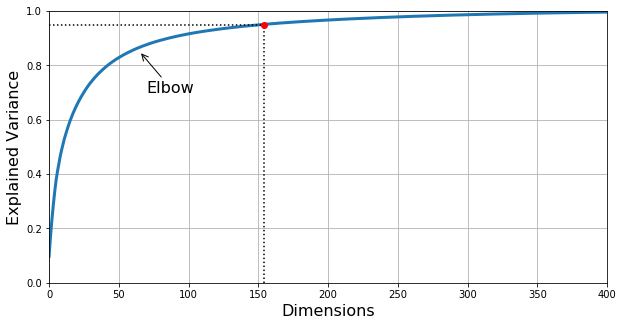

In [26]:
plt.figure(figsize=(10,5))
# 绘制 维度-可解释方差
plt.plot(cumsum, linewidth=3)
plt.plot([d,d],[0,0.95],"k:")
plt.plot([0,d],[0.95,0.95],"k:")
plt.plot(d,0.95,"ro")
plt.annotate("Elbow",xy=(65,0.85),xytext=(70,0.7),arrowprops=dict(arrowstyle="->"),fontsize=16)
plt.axis([0,400,0,1])
plt.xlabel("Dimensions",fontsize=16)
plt.ylabel("Explained Variance",fontsize=16)
 
plt.grid(True)
 
plt.show()

In [27]:
# PCA 指定降到d维
pca = PCA(n_components = 153)
# 训练 降低维度
X_reduced = pca.fit_transform(X_train)

np.sum(pca.explained_variance_ratio_)

0.9495475506933302

In [28]:
# 反转 重建维度（普通 PCA）
X_recovered = pca.inverse_transform(X_reduced)

X_reduced_pca = X_recovered  # 拷贝变量以便后面使用
X_recovered.shape

(52500, 784)

In [29]:
# （2）PCA 指定 要保留的方差率
pca = PCA(n_components=0.95)
# 训练 降至满足方差率的维度 d
X_reduced = pca.fit_transform(X_train)

In [30]:
pca.n_components_

154

In [31]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

### 8.3.7 PCA 压缩

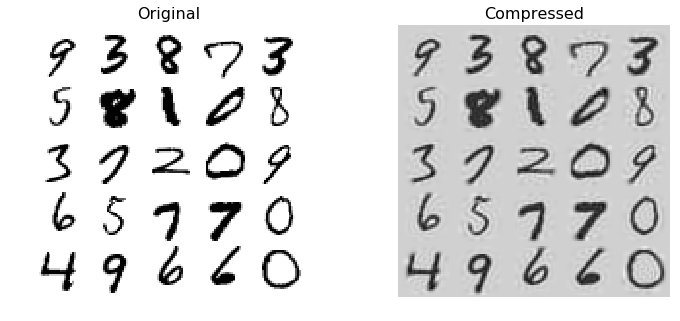

In [32]:
def plot_digits(instances, images_per_row=5, **options):
    
    # 每行几张图
    images_per_row = min(len(instances), images_per_row)
    # 共几行
    n_rows = (len(instances)-1)//images_per_row + 1
    
    # 每张图的尺寸
    size = 28
    images = [instance.reshape(size, size) for instance in instances]
    
    # 初始化 每行的图片
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size*n_empty)))
    
    # 填充 每行的图片
    for row in range(n_rows):
        rimages = images[ row * images_per_row:(row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    # 合并 所有行的图片
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(12,5))

# 左图
plt.subplot(121)
# 原始数据
plot_digits(X_train[::2100])  # 每2100取1个数据
plt.title("Original", fontsize=16)

# 右图
plt.subplot(122)
# 重建数据
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
 
plt.show()

### 8.3.8 随机 PCA

In [33]:
# 随机 PCA - svd_solver="randomized"
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

### 8.3.9 增量 PCA

In [34]:
from sklearn.decomposition import IncrementalPCA

# 100 个批次
n_batches = 100

# 增量 PCA - IncrementalPCA
inc_pca = IncrementalPCA(n_components=154)
# 数据集分为 100 个批次
for X_batch in np.array_split(X_train, n_batches):
    print(".",end="")
    # 小批量降维
    inc_pca.partial_fit(X_batch)
    
# 获得最终降维数据
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [35]:
X_reduced_inc_pca = X_recovered  # 拷贝以便后面使用
X_reduced_inc_pca.shape

(52500, 784)

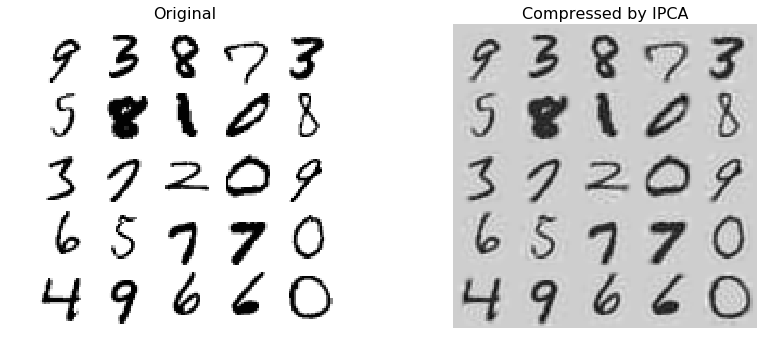

In [36]:
# 反转 重建维度（增量 PCA）
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)
 
plt.figure(figsize=(12,5))

# 左图
plt.subplot(121)
# 原始数据
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
 
# 右图
plt.subplot(122)
# 重建数据
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Compressed by IPCA",fontsize=16)
 
plt.tight_layout()
plt.show()

In [37]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [38]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

True

In [39]:
filename = "my_mnist.data"
m,n = X_train.shape

# 将存储在 磁盘上的二进制文件 中的 大型数组 当做是在 内存 中一样来操作
X_mm = np.memmap(filename, dtype="float32", mode="write",shape=(m,n))
X_mm[:] = X_train
del X_mm

In [40]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly",shape=(m,n))

# 每个批次大小
batch_size = m // n_batches
# 增量 PCA - IncrementalPCA
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
# 基于内存 降维 小批次数据
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

## 8.4 内核 PCA

In [41]:
from sklearn.decomposition import KernelPCA

# 原数据（瑞士卷数据集）
X, t = make_swiss_roll(n_samples=1000, noise=0.3, random_state=42)

# RBF内核 PCA
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
# 训练 降低至 2 维
X_reduced = rbf_pca.fit_transform(X)
X_reduced.shape

(1000, 2)

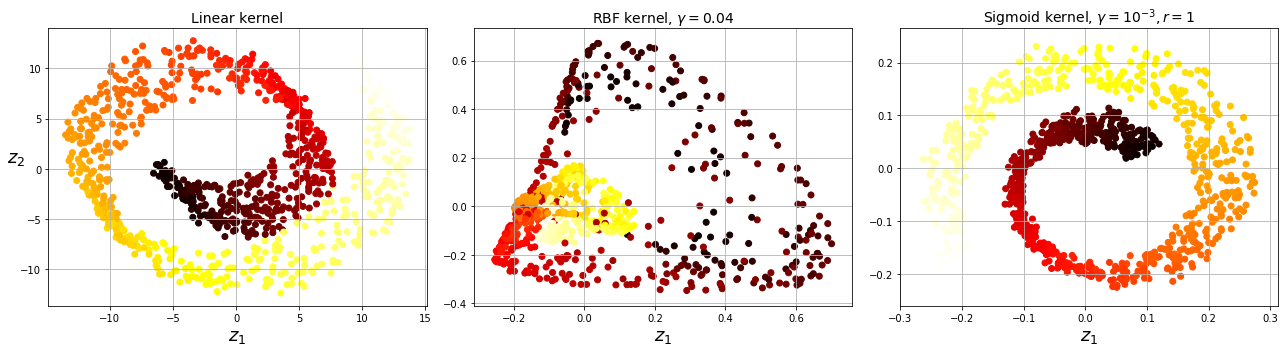

In [62]:
# 线性内核 PCA
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
# RBF内核 PCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
# Sigmoid内核 PCA
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
 
y = t > 6.9
 
plt.figure(figsize=(18, 5))

for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    # 训练 降低至 2 维
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    # plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    # plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    
    # 绘制 降维后的数据
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.tight_layout()
plt.show()

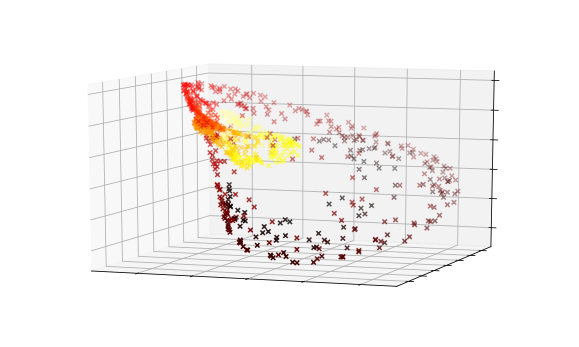

In [63]:
plt.figure(figsize=(10,6))

# 反转 重建维度（RBF内核 PCA）
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
# 绘制 重建后的数据
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
 
plt.show()

### 选择内核并调整超参数

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# （1）网格搜索

# 流水线
clf = Pipeline([
        # 内核 PCA 不指定具体的 内核、超参数
        ("kpca", KernelPCA(n_components=2)),
        # 逻辑回归 lbfgs 拟牛顿法的一种 利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数
        ("log_reg", LogisticRegression(solver="lbfgs"))])

# 网格搜索 最佳性能的 内核、超参数
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [53]:
# 最佳性能的 内核、超参数
grid_search.best_params_

{'kpca__gamma': 0.04555555555555556, 'kpca__kernel': 'rbf'}

In [65]:
# （2）重建误差 fit_inverse_transform=True 才能反转重建 求均方根

# 定义最佳性能的 PCA 
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
# 训练 降维至 2维
X_reduced = rbf_pca.fit_transform(X)
# 反转 重建至 3维
X_preimage = rbf_pca.inverse_transform(X_reduced)
 
from sklearn.metrics import mean_squared_error

# 求均方根
mean_squared_error(X, X_preimage)

32.87703147614693

## 8.5 LLE

In [67]:
from sklearn.manifold import LocallyLinearEmbedding

# 原数据（瑞士卷数据集）
X,t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

# 局部线性嵌入 PCA
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)

# 训练 降低至 2 维
X_reduced = lle.fit_transform(X)
 
X_reduced.shape

(1000, 2)

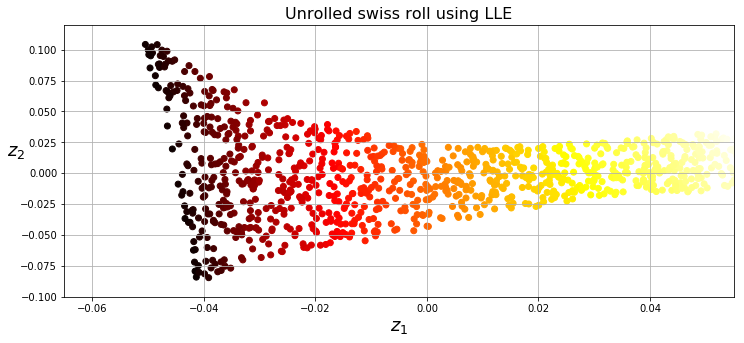

In [68]:
plt.figure(figsize=(12,5))
# 绘制 降维后的数据
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=t, cmap=plt.cm.hot)
plt.title("Unrolled swiss roll using LLE", fontsize=16)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
 
plt.show()